In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import peakutils
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]

In [5]:
Hay_data_train = pd.read_excel('Hay_ensile_data/DL_ENsH_CP_train_1.xlsx')
Hay_data_val = pd.read_excel('Hay_ensile_data/validation.xlsx')

In [11]:
def convert_abs(input):
    for i in range(input.shape[0]):
        input.iloc[i] = 2-np.log10(input.iloc[i])
    return input


In [12]:
CP = Hay_data_train['CP']
sample_ID = Hay_data_train['Sample ID']
scanner_ID = Hay_data_train['Scanner ID']
spectra_ref = Hay_data_train.drop(['Scanner ID','Sample ID','CP'],axis=1)
wav = spectra_ref.keys()

In [13]:
CP_test = Hay_data_val['CP']
sample_ID_test = Hay_data_val['sampleID']
Scanner_Id  = Hay_data_val['scannerID']
spectra_ref_test = Hay_data_val.drop(['scannerID','sampleID','CP'],axis=1)


<AxesSubplot:>

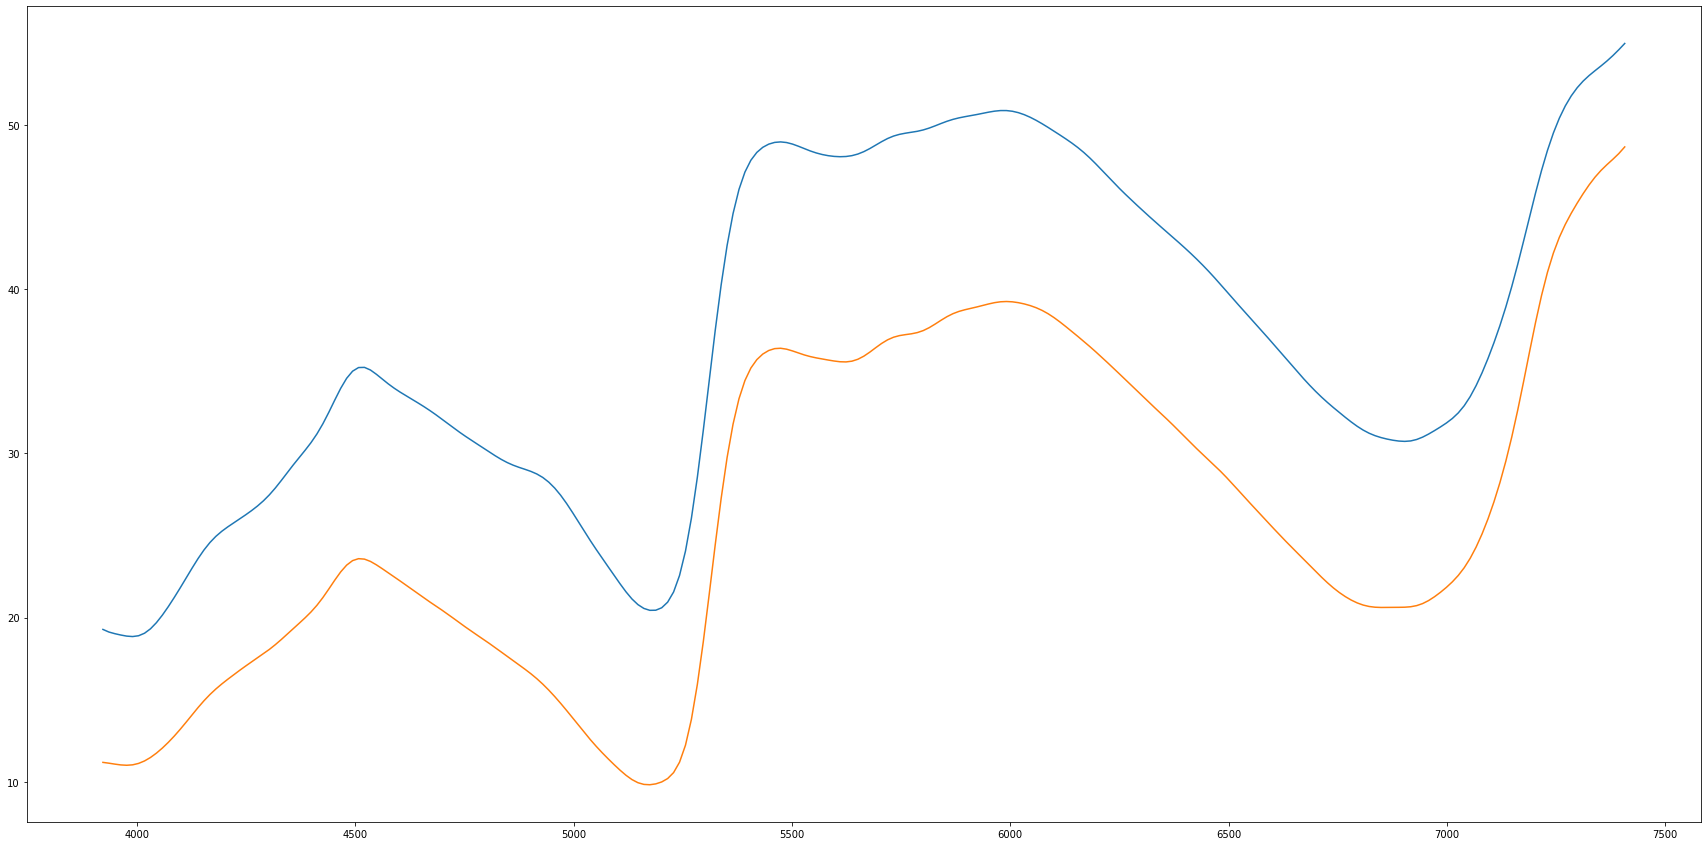

In [14]:
spectra_ref.iloc[0].plot()
spectra_ref_test.iloc[0].plot()

In [15]:
spectra_abs =  convert_abs(spectra_ref.copy(deep=True))
spectra_abs_test = convert_abs(spectra_ref_test.copy(deep=True))

<AxesSubplot:>

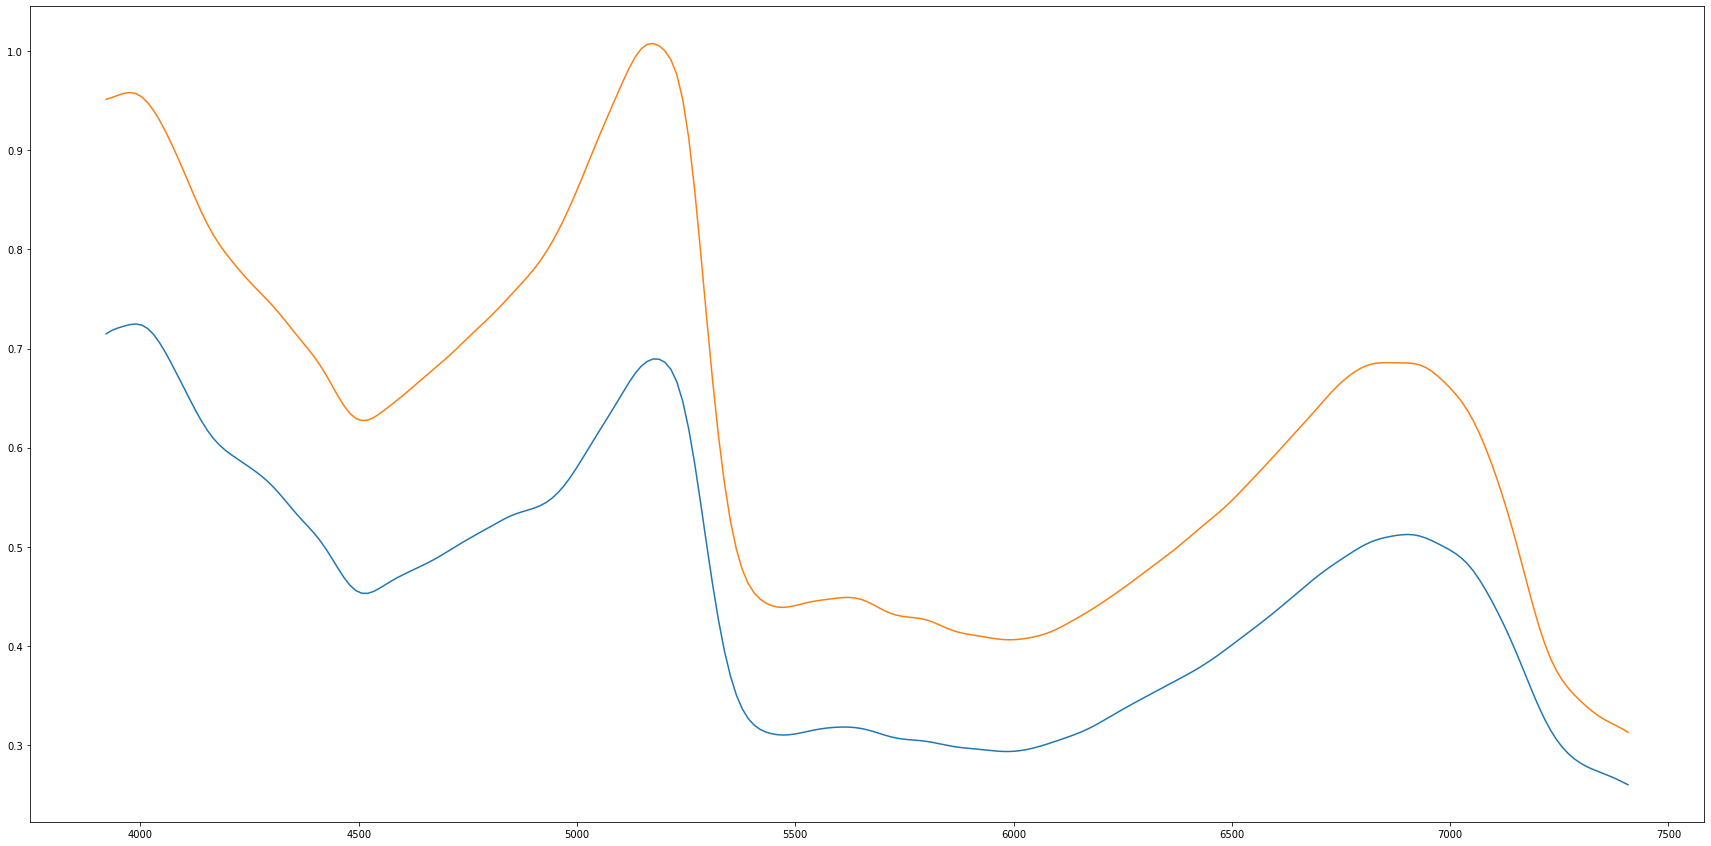

In [16]:
spectra_abs.iloc[0].plot()
spectra_abs_test.iloc[0].plot()

In [17]:

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

In [18]:
spectra_snv = snv(spectra_abs.copy(deep=True).to_numpy())
spectra_snv = pd.DataFrame(spectra_snv,columns=wav)

In [19]:
spectra_snv_test = snv(spectra_abs_test.copy(deep=True).to_numpy())
spectra_snv_test = pd.DataFrame(spectra_snv_test,columns=wav)

<AxesSubplot:>

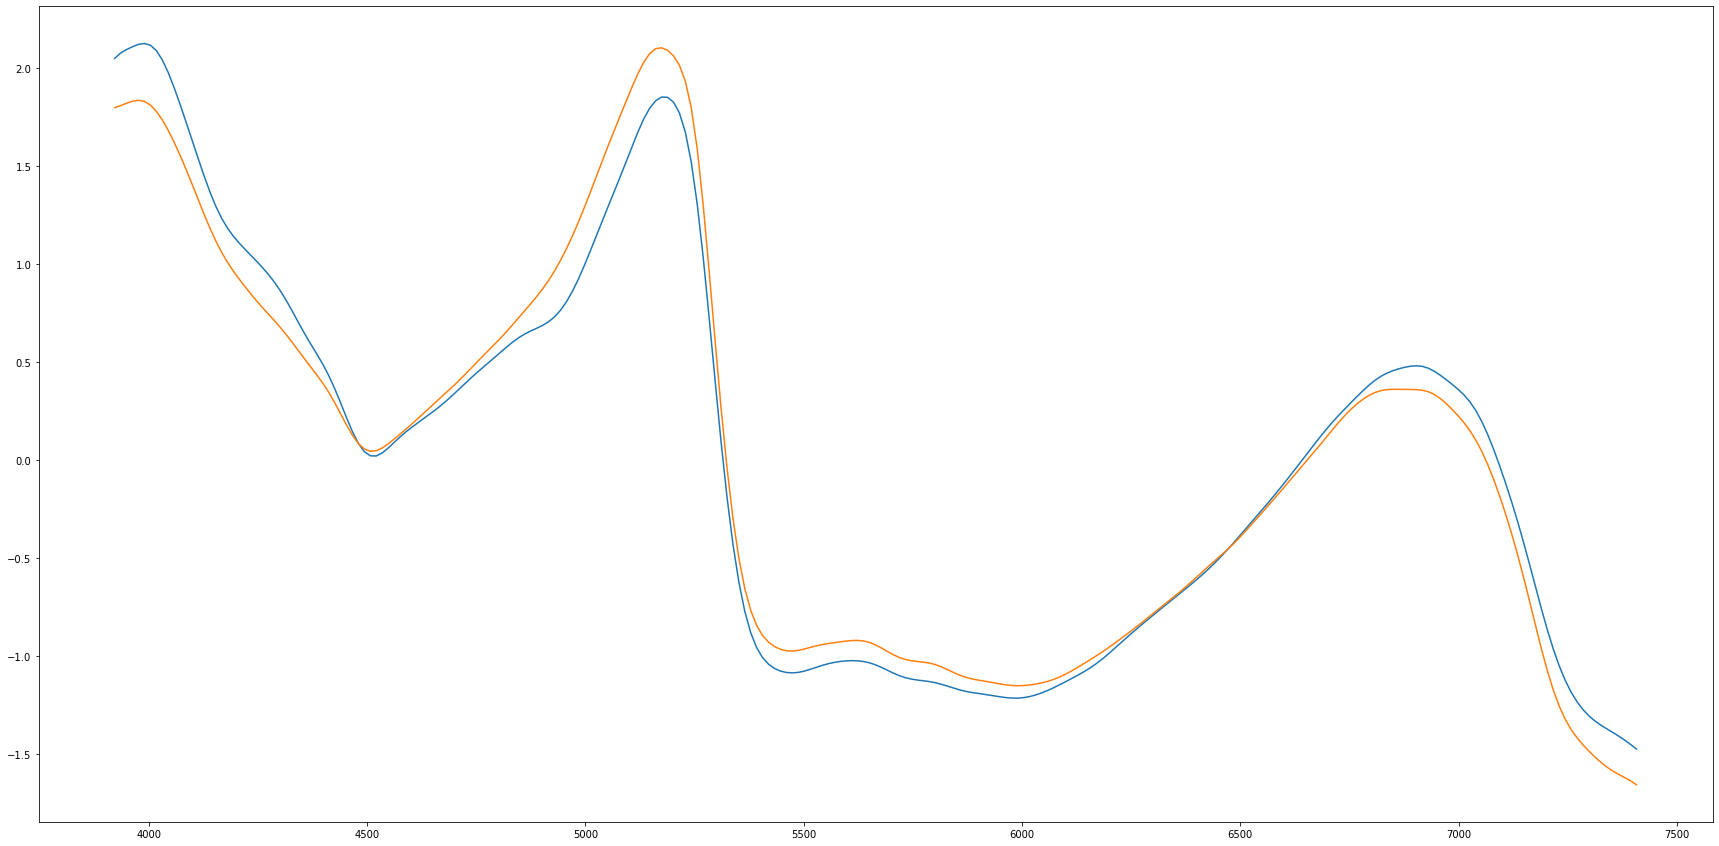

In [20]:
spectra_snv.iloc[0].plot()
spectra_snv_test.iloc[0].plot()

In [21]:
def remove_baseline(spectra,fit_order):
    base = peakutils.baseline(spectra.iloc[0], fit_order)
    for i in range(spectra.shape[0]):
        spectra.iloc[i] = spectra.iloc[i] - base
    
    return spectra

<AxesSubplot:>

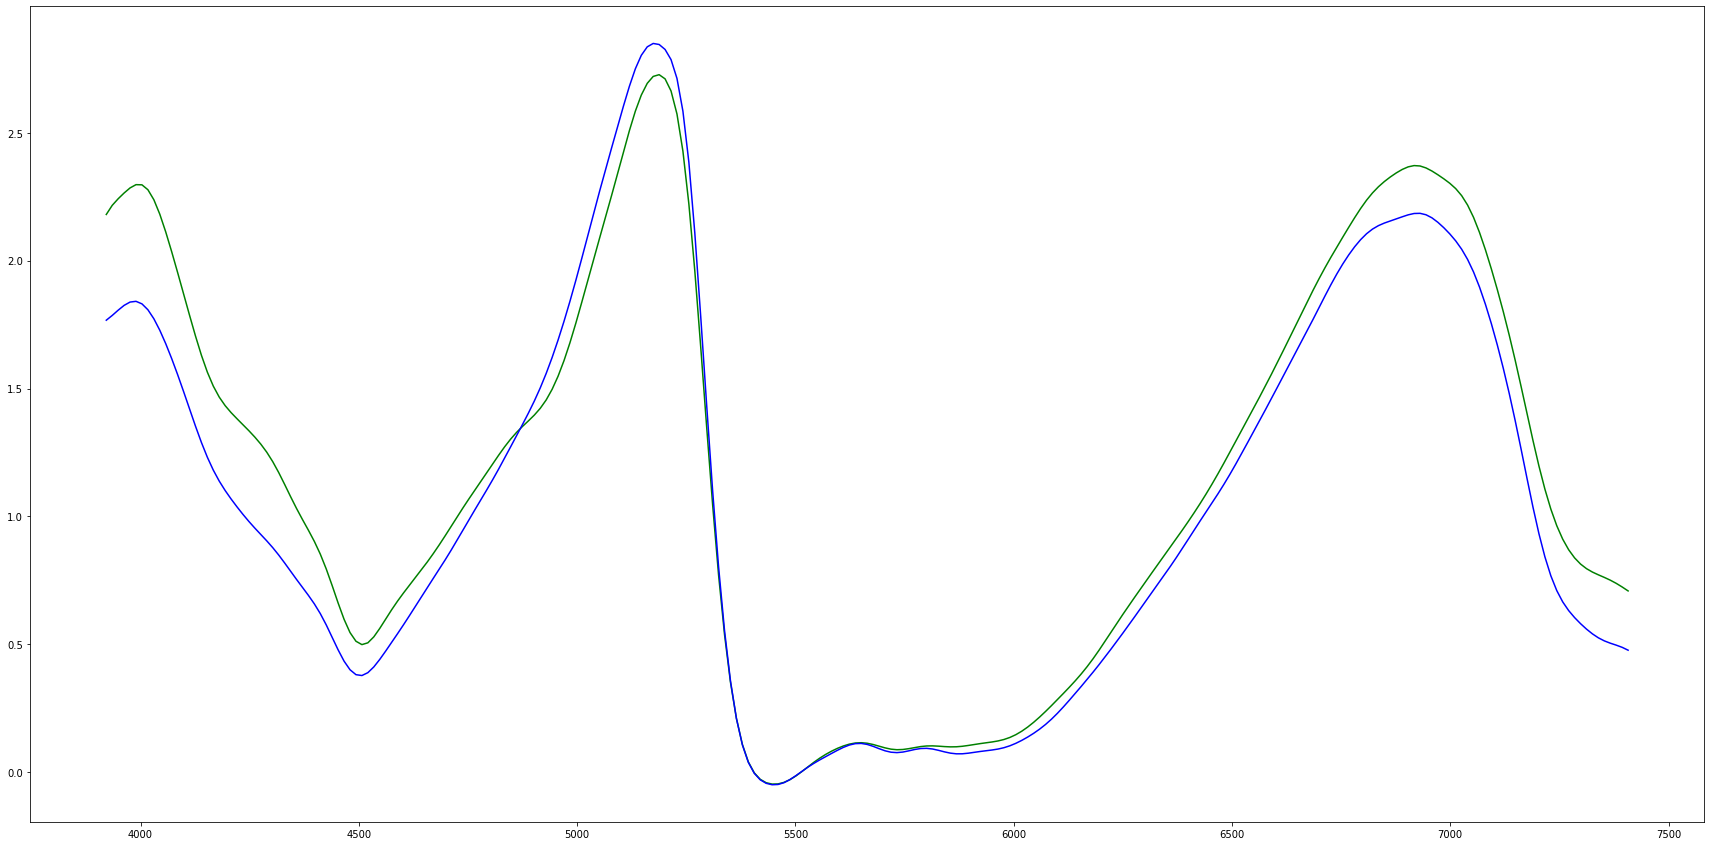

In [22]:
spectra_snv_detrended = remove_baseline(spectra_snv,1)
spectra_snv_detrended_test = remove_baseline(spectra_snv_test,1)
spectra_snv_detrended.iloc[0].plot(color="green")
spectra_snv_detrended_test.iloc[0].plot(color="blue")


In [27]:
pls = PLSRegression(n_components = 20)
pls.fit(spectra_snv_detrended,CP)

/home/ashry/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


PLSRegression(n_components=20)

In [28]:
pls.score(spectra_snv_detrended_test,CP_test)

/home/ashry/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


-1.6093443932109128

In [65]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.5,
                max_depth = 10, alpha = 10, n_estimators = 25)
xg_reg.fit(spectra_abs,CP)

/home/ashry/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [66]:
xg_reg.score(spectra_abs_test,CP_test)

-0.046469241142703455